# Limpeza dos dados

In [48]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, normaltest

In [49]:
# Leitura dos dados

dataset_constructs = "promoters_RBS.xlsx"
dataset_promoters = "promoters.xlsx"
dataset_rbs = "RBS.xlsx"


warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl') # suprimir um aviso por causa do rodapé e do cabeçalho (não consegue ler)

df_constructs = pd.read_excel(dataset_constructs)
promoters_df = pd.read_excel(dataset_promoters)
rbs_df = pd.read_excel(dataset_rbs)

In [50]:
# Filtragem inicial

"""
bad.promo -> `TRUE` se o promotor do construct apresenta problemas técnicos.

min.prot -> `TRUE` se `prot` (proteína) está abaixo do limite inferior de deteção, indica dados não confiáveis (subestimados).

max.prot`  -> `TRUE` se `prot` (proteína) está acima do limite superior de deteção, indica saturação do sinal (sobrestimados).

bad.prot -> `TRUE` se dados de proteína não são confiáveis.

bad.DNA -> `TRUE` se contagens de DNA são insuficientes.

bad.RNA -> `TRUE` se dados de RNA não são confiáveis (ex: baixa contagem + baixo DNA)

min.RNA -> `TRUE` se ambas replicas de RNA estão abaixo do limite.

"""


# Preservar linhas com 'False'
df_clean = df_constructs[
    (df_constructs["bad.promo"] == False) &
    (df_constructs["bad.prot"] == False) &
    (df_constructs["bad.DNA"] == False) &
    (df_constructs["bad.RNA"] == False) &
    (df_constructs["min.prot"] == False) &
    (df_constructs["max.prot"] == False) &
    (df_constructs["min.RNA"] == False)
]

# Remover todas as linhas com NA em 'prot' (sem dados de expressão)
df_clean = df_clean.dropna(subset=['prot'])

In [28]:
# Testes à normalidade
stat_prot, p_prot = shapiro(df_clean['prot'])
print(f"p = {p_prot}")

if p_prot < 0.05:
    print("Rejeita-se H0 → os dados de 'prot' não seguem normalidade.")
else:
    print("Não se rejeita H0 → os dados podem ser normais.")


stat_DNA, p_DNA = shapiro(df_clean['count.DNA'])
print(f"p = {p_DNA}")

if p_DNA < 0.05:
    print("Rejeita-se H0 → os dados de 'count.DNA' não seguem normalidade.")
else:
    print("Não se rejeita H0 → os dados podem ser normais.")


stat_RNA, p_RNA = shapiro(df_clean['count.RNA'])
print(f"p = {p_RNA}")

if p_RNA < 0.05:
    print("Rejeita-se H0 → os dados de 'count.RNA' não seguem normalidade.")
else:
    print("Não se rejeita H0 → os dados podem ser normais.")

p = 7.857680826090657e-73
Rejeita-se H0 → os dados de 'prot' não seguem normalidade.
p = 3.292514724388838e-50
Rejeita-se H0 → os dados de 'count.DNA' não seguem normalidade.
p = 1.0388726987113645e-71
Rejeita-se H0 → os dados de 'count.RNA' não seguem normalidade.


C:\Users\joama\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9336.
  res = hypotest_fun_out(*samples, **kwds)


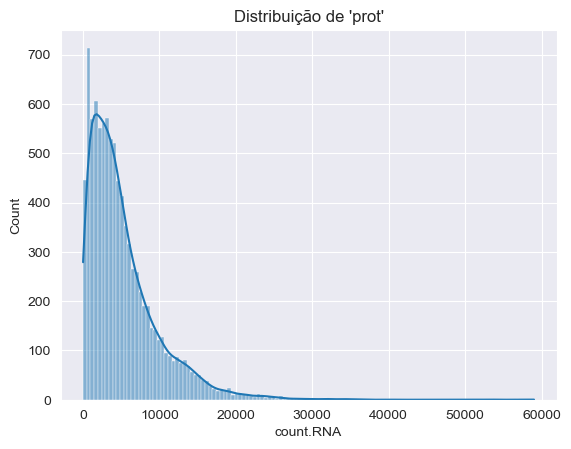

In [23]:
# Histogramas de distribuição
sns.histplot(df_clean['prot'], kde=True)
plt.title("Distribuição de 'prot'")
plt.show()

sns.histplot(df_clean['count.DNA'], kde=True)
plt.title("Distribuição de 'count.DNA'")
plt.show()

sns.histplot(df_clean['count.RNA'], kde=True)
plt.title("Distribuição de 'count.RNA'")
plt.show()

In [51]:
# 1. Filtragem por outliers na coluna 'prot'
Q1_prot = df_clean['prot'].quantile(0.25)
Q3_prot = df_clean['prot'].quantile(0.75)
IQR_prot = Q3_prot - Q1_prot

lower_prot = Q1_prot - 1.5 * IQR_prot
upper_prot = Q3_prot + 1.5 * IQR_prot

df_step1 = df_clean[(df_clean['prot'] >= lower_prot) & (df_clean['prot'] <= upper_prot)]

# 2. Filtragem por outliers na coluna 'count.DNA'
Q1_dna = df_step1['count.DNA'].quantile(0.25)
Q3_dna = df_step1['count.DNA'].quantile(0.75)
IQR_dna = Q3_dna - Q1_dna

lower_dna = Q1_dna - 1.5 * IQR_dna
upper_dna = Q3_dna + 1.5 * IQR_dna

df_step2 = df_step1[(df_step1['count.DNA'] >= lower_dna) & (df_step1['count.DNA'] <= upper_dna)]

# 3. Filtragem por outliers na coluna 'count.RNA'
Q1_rna = df_step2['count.RNA'].quantile(0.25)
Q3_rna = df_step2['count.RNA'].quantile(0.75)
IQR_rna = Q3_rna - Q1_rna

lower_rna = Q1_rna - 1.5 * IQR_rna
upper_rna = Q3_rna + 1.5 * IQR_rna

df_filtered = df_step2[(df_step2['count.RNA'] >= lower_rna) & (df_step2['count.RNA'] <= upper_rna)]

# Reiniciar índices por conveniência
df_filtered = df_filtered.reset_index(drop=True)

# Normalização da coluna 'prot' após remoção de outliers (média = 0, desvio padrão = 1)
df_filtered = df_filtered.copy()
df_filtered['prot_z'] = scaler.fit_transform(df_filtered[['prot']])

# Estatísticas
num_linhas_o = len(df_constructs)
num_linhas = len(df_filtered)
perc = (num_linhas/num_linhas_o)*100

print(f"Número de linhas no dataset original: {num_linhas_o}")
print(f"Número de linhas no dataset filtrado: {num_linhas}")
print(f"Percentagem de linhas removidas: {100-perc:.2f}%")


Número de linhas no dataset original: 12655
Número de linhas no dataset filtrado: 8794
Percentagem de linhas removidas: 30.51%


In [58]:
# Preparação do dataset final

# --- Definir spacer ---
spacer = "AACTT"  # Spacer neutro e curto, sem codões de start ou stop

# --- Eliminar espaços nas sequências dos datasets originais (caso existam) ---
promoters_df['Sequence'] = promoters_df['Sequence'].str.replace(" ", "")
rbs_df['Sequence'] = rbs_df['Sequence'].str.replace(" ", "")

# --- Merge com sequências dos promotores ---
df_merged = df_filtered.merge(
    promoters_df[['full.name', 'Sequence']],
    left_on='Promoter.TTL',
    right_on='full.name',
    how='left'
)
df_merged = df_merged.rename(columns={'Sequence': 'promoter_seq'}).drop(columns='full.name')

# --- Merge com sequências dos RBS ---
df_merged = df_merged.merge(
    rbs_df[['full.name', 'Sequence']],
    left_on='RBS.TTL',
    right_on='full.name',
    how='left'
)
df_merged = df_merged.rename(columns={'Sequence': 'rbs_seq'}).drop(columns='full.name')

# --- Construção da sequência final (Promotor + Spacer + RBS) ---
df_merged['full_sequence'] = df_merged['promoter_seq'] + spacer + df_merged['rbs_seq']


# Selecionar apenas as colunas essenciais
df_minimal = df_merged[['target', 'full_sequence', 'prot_z']].rename(columns={
    'full_sequence': 'sequence'
})

# Exportar para CSV
df_minimal.to_csv("training_data.csv", index=False)

# Exportar para Excel (apenas para verificar se está tudo ok)
df_minimal.to_excel("dataset_final.xlsx", index=False)